In [ ]:
!git clone https://github.com/pranavp369/Warwick_Dataset.git

Cloning into 'Warwick_Dataset'...
remote: Enumerating objects: 337, done.
remote: Total 337 (delta 0), reused 0 (delta 0), pack-reused 337
Receiving objects: 100% (337/337), 172.06 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Updating files: 100% (332/332), done.


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 5.9 MB/s eta 0:00:00


In [ ]:
#Import Packages
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , random_split
from torch.utils.data.distributed import Dataset
import time
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from PIL import Image
from pathlib import Path
from torchmetrics.functional import dice
import copy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Task 1 : Classification of Hand-Written digits using a Convolutional Neural Network**


---

In this section, the code for classification of hand-written digits using CNN developed. The classification model is trained and tested on the MNIST dataset with 10 output labels (0-9).

In [ ]:
#Getting MNIST Dataset using TorchVision
traindataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testdataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#Function to Load test data and extract them
def test_loader_1(dataset):
    data_size = len(dataset)
    data_loader = DataLoader(dataset, batch_size = data_size, shuffle = False)
    
    return next(iter(data_loader))

In [ ]:
#Function to get the Accuracy of the model
def get_accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

In [ ]:
#Defining the Neural Network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
#Defining Convolutional Neural Network
class ConvolutionNN(nn.Module):

    def __init__(self):
        super(ConvolutionNN,self).__init__()

        self.flatten = nn.Flatten()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1),
                                   nn.Dropout(p=0.2),
                                   nn.ReLU(),
                                   #nn.Tanh(),
                                   nn.MaxPool2d(kernel_size=2,stride=2)
                                   )
      
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   #nn.Tanh(),
                                   nn.MaxPool2d(kernel_size=2,stride=2))
      
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
                                   nn.ReLU()
                                   #nn.Tanh()
                                   )
        
      
        self.fc1 = nn.Linear(32*7*7,200)

        self.fc2 = nn.Linear(200,100)

        self.fc3 = nn.Linear(100,10)

        
        
        self.softmax = nn.Softmax(dim=1)

        #(57344x7 and 1000x900)
    
    def forward(self,x):

        #x = self.flatten(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        output = self.softmax(x)

        return output   

In [ ]:
net = ConvolutionNN()
net

ConvolutionNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
#The function defined to train and validate the model
def A3_1_model(model,trainset,testset,alpha,optimizer,batchsize,no_of_epochs):

    model.to(device)
    
    best_model = copy.deepcopy(model.state_dict())
    
    trainingdata = DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)
    X_test,y_test = test_loader_1(testset)

    training_loss = []
    training_accuracy = []
    training_iter = []
    test_accuracy = []
    test_loss = []
    test_iter = []
    iter_count = 0

    best_acc = 0
    best_epoch = 0


    for i in range(no_of_epochs):
        start = time.time()

        training_acc_int = []
        training_loss_int = []
        testing_acc_int = []
        testing_loss_int = []


        for train in trainingdata:
            X_train,y_train  = train[0].to(device),train[1].to(device)
            

            optimizer.zero_grad()
            output = model(X_train)
            cross_loss = nn.CrossEntropyLoss()
            loss = cross_loss(output,y_train)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                training_loss_int.append(loss.item())
                training_acc_int.append(get_accuracy(output,y_train).item())

                X_test,y_test = X_test.to(device),y_test.to(device)
                test_output = model(X_test)
                test_loss_def = nn.CrossEntropyLoss()
                test_loss_i = test_loss_def(test_output,y_test)

                testing_loss_int.append(test_loss_i.item())
                testing_acc_int.append(get_accuracy(test_output,y_test).item())

                training_iter.append(iter_count)
                test_iter.append(iter_count)
                iter_count = iter_count +1
        
        epoch_acc = mean(training_acc_int)

        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = i
          
        training_accuracy.append(mean(training_acc_int))
        test_accuracy.append(mean(testing_acc_int))
        training_loss.append(mean(training_loss_int))
        test_loss.append(mean(testing_loss_int))
        training_iter.append(i)
        test_iter.append(i)

        print(f"##########   Epoch {i} out of {no_of_epochs}   ##########")
        print(f"Training Accuracy : {100*training_accuracy[-1]}")
        print(f"Training Loss: {training_loss[-1]}")
        print(f"Testing Accuracy: {100*test_accuracy[-1]}")
        print(f"Testing Loss: {test_loss[-1]}")
        end = time.time()
        print(f"The time taken for Epoch {i+1} is {end-start}")

        model.load_state_dict(best_model)

    return model,training_accuracy,test_accuracy,training_loss,test_loss,training_iter,test_iter, best_epoch       


In [ ]:
model = ConvolutionNN()

#Setting up the Hyper-parameters
alpha = 0.09
optimizer = torch.optim.SGD(model.parameters(), lr = alpha, momentum= 0.9)#, momentum= 0.9
optimizer_adam = torch.optim.Adam(model.parameters(), lr = alpha,betas=(0.9, 0.999))
batchsize = 128

net,training_accuracy,test_accuracy,training_loss,test_loss,training_iter,test_iter,best_epoch = A3_1_model(model,traindataset,testdataset,alpha,optimizer,batchsize,100)

##########   Epoch 0 out of 100   ##########
Training Accuracy : 85.40056415204046
Training Loss: 1.6093629715539246
Testing Accuracy: 86.08671427408515
Testing Loss: 1.6024919153530714
The time taken for Epoch 1 is 21.047162294387817
##########   Epoch 1 out of 100   ##########
Training Accuracy : 95.40411780383795
Training Loss: 1.5070699145798998
Testing Accuracy: 95.8405520361878
Testing Loss: 1.5026541437421526
The time taken for Epoch 2 is 13.787265300750732
##########   Epoch 2 out of 100   ##########
Training Accuracy : 95.15536159340506
Training Loss: 1.5094445145714765
Testing Accuracy: 95.39276947344798
Testing Loss: 1.5070575559571353
The time taken for Epoch 3 is 13.853631734848022
##########   Epoch 3 out of 100   ##########
Training Accuracy : 95.72505775545197
Training Loss: 1.5036357287913242
Testing Accuracy: 96.02622373271853
Testing Loss: 1.5007705576638424
The time taken for Epoch 4 is 14.765385627746582
##########   Epoch 4 out of 100   ##########
Training Accurac

KeyboardInterrupt: ignored

In [ ]:
#Finding the Training accuracy on the best performing model.

X_train,y_train = test_loader_1(traindataset)
X_train,y_train = X_train.to(device),y_train.to(device)
train_output = model(X_train)

print(get_accuracy(train_output,y_train).item())

0.9950667023658752


In [ ]:
#Finding the Test Accuracy on the best performing model.

X_test,y_test = test_loader_1(testdataset)
X_test,y_test = X_test.to(device),y_test.to(device)
test_output = model(X_test)

print(get_accuracy(test_output,y_test).item())
ind = []
x_ind =[]

for i in range(len(y_test)):
    if(test_output[i].argmax() != y_test[i]):
        ind.append(X_test[i])
        x_ind.append(i)


0.9896000027656555


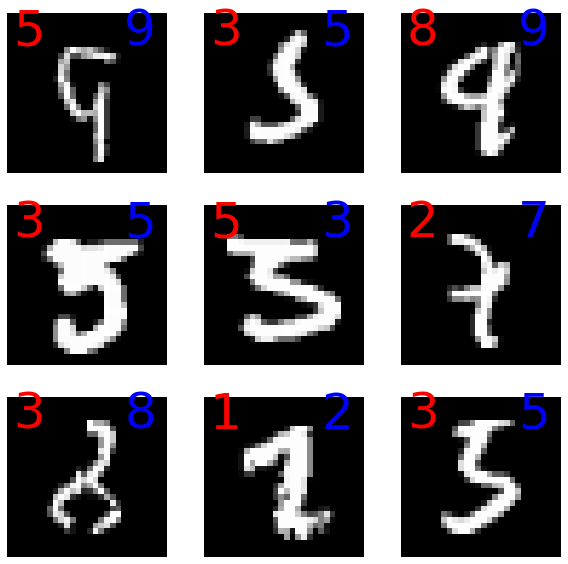

In [ ]:
#Plotting the missclassification labels
def mis_plot(ind,test_out,y_test,x_ind):    
    
    plt.figure(figsize=(10,10))
    plt.text(0.5,0.5,"True Labels",color = 'Red')

    plt.subplot(3,3,1)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[0], nrow=1, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[0]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[0]].item()),color = "Blue",fontsize = 50)
    
    plt.subplot(3,3,2)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[2], nrow=1, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[2]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[2]].item()),color = "Blue",fontsize = 50)
    
    plt.subplot(3,3,3)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[3], nrow=1, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[3]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[3]].item()),color = "Blue",fontsize = 50)

    plt.subplot(3,3,4)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[4], nrow=3, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[4]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[4]].item()),color = "Blue",fontsize = 50)
    

    plt.subplot(3,3,5)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[5], nrow=3, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[5]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[5]].item()),color = "Blue",fontsize = 50)

    plt.subplot(3,3,6)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[6], nrow=3, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[6]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[6]].item()),color = "Blue",fontsize = 50)

    plt.subplot(3,3,7)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[7], nrow=3, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[7]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[7]].item()),color = "Blue",fontsize = 50)

    plt.subplot(3,3,8)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[8], nrow=3, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[8]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[8]].item()),color = "Blue",fontsize = 50)

    plt.subplot(3,3,9)
    plt.axis("off")
    #plt.title(title1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(ind[9], nrow=3, padding=5, 
    normalize=True).cpu(),(1,2,0)))
    plt.text(0.5,5,str(test_out[x_ind[9]].argmax().item()),color = "Red",fontsize = 50)
    plt.text(20,5,str(y_test[x_ind[9]].item()),color = "Blue",fontsize = 50)
    

mis_plot(ind,test_output,y_test,x_ind)

In [ ]:
#Function to plot the costs per iteration
def loss_iteration_graph(iter,costs):
  costs = np.array(costs)
  costs.reshape(1,-1)
  
  plt.figure()
  plt.plot(iter,costs)
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Loss vs Iteration')
  #plt.savefig('Lossvsiterations.png')

#Function to plot the accuracy in the training data per iteration
def trainingaccuracy_iterations_graph(iter,training_accuracies):
  plt.figure()
  plt.plot(iter,training_accuracies)
  plt.xlabel('Epochs')
  plt.ylabel('Training accuracy')
  plt.title('Training Accuracy')
  #plt.savefig('trainingaccuracyvsiterations.png')

#Function to plot the accuracy in the testing data per iteration
def testingaccuracy_iterations_graph(iter,test_accuracies):
  plt.figure()
  plt.plot(iter,test_accuracies)
  plt.xlabel('Epochs')
  plt.ylabel('Test Accuracy')
  plt.title('Test accuracy')
  #plt.savefig('testaccuracyvsiterations.png')

In [ ]:
#Iterations to Epochs
iter = []
for i in range(int(len(training_iter)/470)):
    iter.append(i)

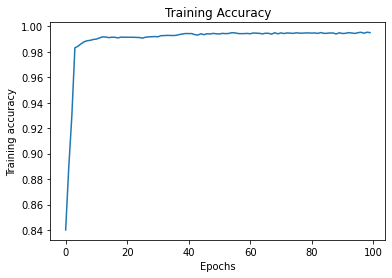

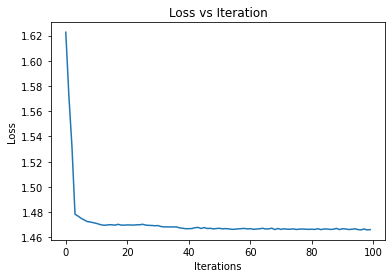

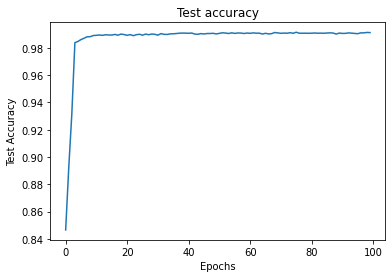

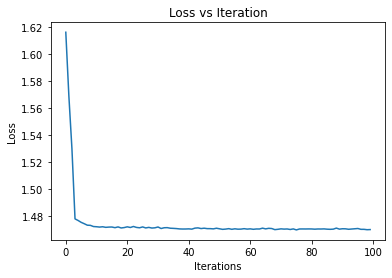

In [ ]:
#Training Accuracy Plot
trainingaccuracy_iterations_graph(iter,training_accuracy)

#Training Loss Plot
loss_iteration_graph(iter,training_loss)

#Testing Accuracy Plot
testingaccuracy_iterations_graph(iter,test_accuracy)

#Testing Loss Plot
loss_iteration_graph(iter,test_loss)

In [ ]:
data_size = len(testdataset)
testloader = DataLoader(testdataset, batch_size = data_size, shuffle = False)

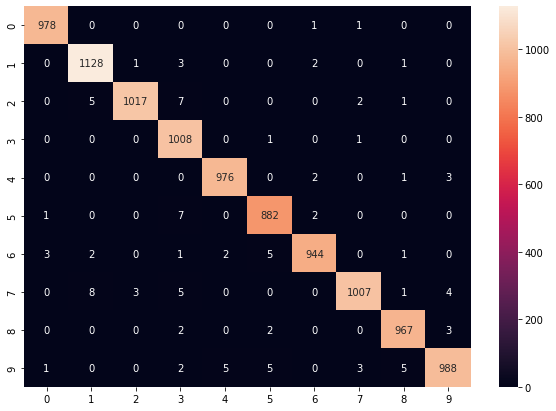

In [ ]:
#Confusion Matrix

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')

color = 'white'
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')
plt.savefig('output.png')

## **Task 2 : Semantic Segmentation of Biomedical Images**


---

In this section, the code for performing semantic segmentation of biomedical images is developed. The segmentation model is trained and tested with the help of Warwick dataset consisting of cell images. The main goal of the task is to develop a Neural Network/CNN method wich performs semantic segmentation and we compare the results with the mask images provided using the Dice Score as the performance metric.

In [ ]:
#Supporting Functions
#Function to Load test data and extract them
def test_loader_2(dataset):
    data_size = len(dataset)
    data_loader = DataLoader(dataset, batch_size = data_size, shuffle = False)
    
    return next(iter(data_loader))

In [ ]:
#Custom DataLoader for Warwick Dataset
class WarwickDataSet(Dataset):

    def __init__(self,img_dir):
      
        self.img_dir = img_dir
        # Path of RGB images of cells
        self.img_path = os.path.join(self.img_dir, "A")

        self.mask_path = os.path.join(self.img_dir, "B")

        self.img_files = [x for x in os.listdir(self.img_path)]
        #print(self.img_files)
        
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, index):

        image = Image.open(os.path.join(self.img_path, self.img_files[index])).convert('RGB')
        mask = Image.open(os.path.join(self.mask_path, self.img_files[index][:-4]+'_anno.bmp'))

        image_transforms = transforms.Compose([
                                     transforms.Resize(size=(256,256)),\
                                     #transforms.RandomHorizontalFlip(p=1.0),\
                                     #transforms.RandomVerticalFlip(p=0.5),\
                                     transforms.ToTensor()])

        # Resizing input and output images
        
        image = image_transforms(image)
        mask = image_transforms(mask)
    
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        
        # Converting mask to binary mask
        mask[mask>0] = 1

        return (image,mask)


In [ ]:
warwickdataset = WarwickDataSet('/content/Warwick_Dataset/Warwick QU Dataset (Released 2016_07_08)')

In [ ]:
train_dataloader = DataLoader(warwickdataset,batch_size = 4,shuffle=True)

In [ ]:
warwickimage, warwickmask = next(iter(train_dataloader))

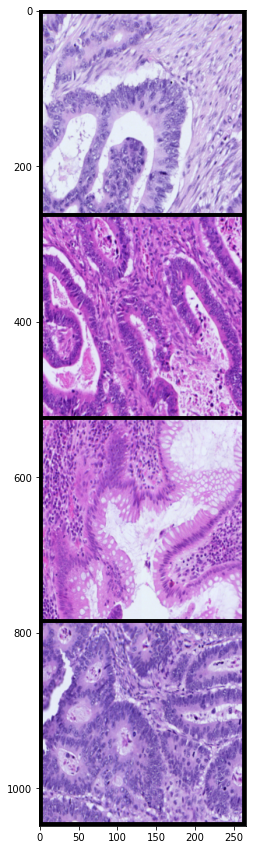

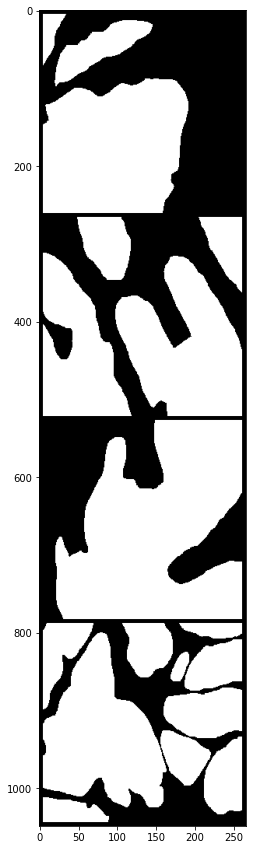

In [ ]:
#Visualising the Images and their respective Masks 
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(torchvision.utils.make_grid(warwickimage, nrow=1, padding=5, normalize=True).cpu(),(1,2,0)))
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(torchvision.utils.make_grid(warwickmask, nrow=1, padding=5, normalize=True).cpu(),(1,2,0)))

In [ ]:
#Training and Test dataset Split
per = 0.2
a = len(warwickdataset)*(1-per)
b = len(warwickdataset)*per
training_dataset, test_dataset = torch.utils.data.random_split(warwickdataset, [int(a),int(b)])
dataset_size = [len(training_dataset),len(test_dataset)]
print(dataset_size)

[132, 33]


In [ ]:
#An Encoder Class to Define the Encoder Network
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder,self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1),
                                   #nn.Dropout(p=0.2),
                                   nn.ReLU())
      
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU())
      
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
                                   nn.Dropout(p=0.2),
                                   nn.ReLU())
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())
        
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                                   #nn.Dropout(p=0.2),
                                   nn.ReLU())

    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        return x


In [ ]:
#An Decoder Class to Define the Decoder Network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()

        self.deconv1 = nn.Sequential(nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1),
                                     nn.BatchNorm2d(64),
                                     #nn.Dropout(p=0.2)
                                    )

        self.deconv2 = nn.Sequential(nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1), 
                                    )
        
        self.deconv3 = nn.Sequential(nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=1),
                                     nn.BatchNorm2d(16)
                                     )
        
        self.deconv4 = nn.Sequential(nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=3,stride=1,padding=1),
                                     nn.Dropout(p=0.2)
                                     )
        
        self.deconv5 = nn.Sequential(nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=8,out_channels=1,kernel_size=3,stride=1,padding=1),
                                     )
        
        #self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)

        return x

In [ ]:
#An AutoEncoder Class to combine the encoder and decoder networks
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()

        self.enc1 = Encoder()
        
        self.dec1 = Decoder()

        self.sigmoid = nn.Sigmoid()

        #self.softmax = nn.Softmax(dim = 1)
    
    def forward(self,x):
        x = self.enc1(x)
        x = self.dec1(x)
        
        out = self.sigmoid(x)
        
        return out


In [ ]:
net = AutoEncoder()
net

In [ ]:
#Function defined to train and validate the model.
def A3_2_model(model,trainset,alpha,optimizer,batchsize,no_of_epochs):

    model.to(device)

    training_loss = []
    training_dice_score = []
    training_iter = []
    val_dice_score = []
    val_loss = []
    val_iter = []
    val_count = 0

    for i in range(no_of_epochs):

        training_dice_int = []
        training_loss_int = []
        val_dice_int = []
        val_loss_int = []

        per = 0.25
        a = len(trainset)*(1-per)
        b = len(trainset)*per
        trainingdataset, valdataset = torch.utils.data.random_split(trainset, [int(a),int(b)])
        dataset_size = [len(trainingdataset),len(valdataset)]

        train_data = DataLoader(trainingdataset, batch_size=8, shuffle=True)
        val_data = test_loader_2(valdataset)
        img_val, mask_val = val_data[0].to(device), val_data[1].to(device)


        for train in train_data:
            img_train,mask_train  = train[0].to(device),train[1].to(device)
            
            optimizer.zero_grad()
            output = model(img_train)
            cross_loss = nn.L1Loss()
            #print(output)
            #print(mask_train)
            loss = cross_loss(output,mask_train)
            dice_score =  dice(output.int(),mask_train.int())
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                training_loss_int.append(loss.item())
                training_dice_int.append(dice_score.item())
                
                #Validation Block
                img_val,mask_val = img_val.to(device),mask_val.to(device)
                val_output = model(img_val)
                dice_score_val =  dice(val_output.int(),mask_val.int())
                val_loss_func = nn.L1Loss()
                val_loss_i = val_loss_func(val_output,mask_val)

                val_loss_int.append(val_loss_i.item())
                val_dice_int.append(dice_score_val.item())

          
        training_dice_score.append(mean(training_dice_int))
        val_dice_score.append(mean(val_dice_int))
        training_loss.append(mean(training_loss_int))
        val_loss.append(mean(val_loss_int))
        training_iter.append(i)
        val_iter.append(i)

        best_model = copy.deepcopy(model.state_dict())

        print(f"##########   Epoch {i+1} out of {no_of_epochs}   ##########")
        print(f"Training Dice Score : {training_dice_score[-1]}")
        print(f"Training Loss: {training_loss[-1]}")
        print(f"Validation Dice Score: {val_dice_score[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")

        model.load_state_dict(best_model)


    return model,training_dice_score,val_dice_score,training_loss,val_loss,training_iter,val_iter



In [ ]:
model = AutoEncoder()

#Setting up the hyper-parameters
alpha = 0.09
optimizer = torch.optim.SGD(model.parameters(), lr = alpha, momentum= 0.9)#, momentum= 0.9
optimizer_adam = torch.optim.Adam(model.parameters(), lr = alpha,betas=(0.9, 0.999))
batchsize = 8

model,training_dice_score,val_dice_score,training_loss,val_loss,training_iter,test_iter = A3_2_model(model,training_dataset,alpha,optimizer,batchsize,100)

##########   Epoch 1 out of 100   ##########
Training Dice Score : 0.5019098428579477
Training Loss: 0.4432300650156461
Validation Dice Score: 0.44440138110747707
Validation Loss: 0.4149221181869507
##########   Epoch 2 out of 100   ##########
Training Dice Score : 0.5439465366877042
Training Loss: 0.3721444790179913
Validation Dice Score: 0.5176292428603539
Validation Loss: 0.35999902395101696
##########   Epoch 3 out of 100   ##########
Training Dice Score : 0.5804714789757361
Training Loss: 0.34456748687303984
Validation Dice Score: 0.5633586461727436
Validation Loss: 0.3253171398089482
##########   Epoch 4 out of 100   ##########
Training Dice Score : 0.595362493625054
Training Loss: 0.3420724685375507
Validation Dice Score: 0.567506308739002
Validation Loss: 0.3379075550116025
##########   Epoch 5 out of 100   ##########
Training Dice Score : 0.5958443650832543
Training Loss: 0.31944376344864184
Validation Dice Score: 0.6189671250490042
Validation Loss: 0.34033291385723996
#######

In [ ]:
#Plotting Dice and Loss Graphs
def training_dice_graph(iter,train_dice):
    dice_score = np.array(train_dice)
    dice_score.reshape(1,-1)
  
    plt.figure()
    plt.plot(iter,dice_score)
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Training Dice Score vs Epoch')

def testing_dice_graph(iter,test_dice):
    dice_score = np.array(test_dice)
    dice_score.reshape(1,-1)
  
    plt.figure()
    plt.plot(iter,dice_score)
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Validation Dice Score vs Epoch')

def training_loss_graph(iter,train_loss):
    loss = np.array(train_loss)
    loss.reshape(1,-1)
  
    plt.figure()
    plt.plot(training_iter,loss)
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Dice Score vs Epoch')

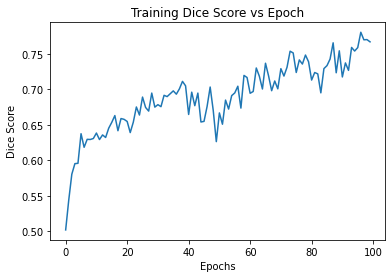

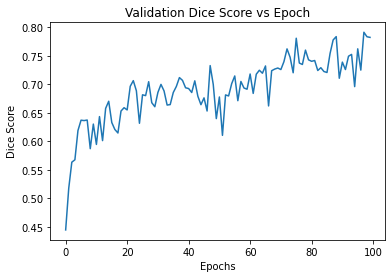

In [ ]:
#Calling the Graph Functions
training_dice_graph(training_iter,training_dice_score)
testing_dice_graph(test_iter,val_dice_score)


In [ ]:
#Testing the model on the Test Dataset
test_data = test_loader_2(test_dataset)

img_test,mask_test = test_data[0].to(device),test_data[1].to(device)
#img_val,mask_val = img_val.to(device),mask_val.to(device)
test_output = model(img_test)
dice_score_test =  dice(test_output.int(),mask_test.int())

print(dice_score_test)

tensor(0.7377, device='cuda:0')


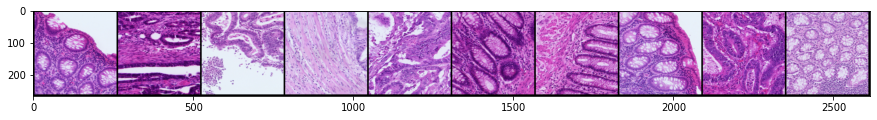

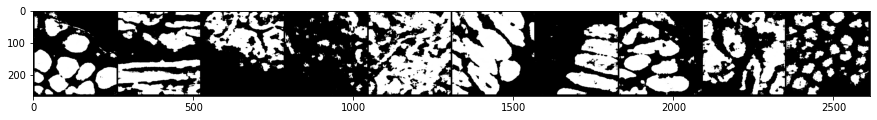

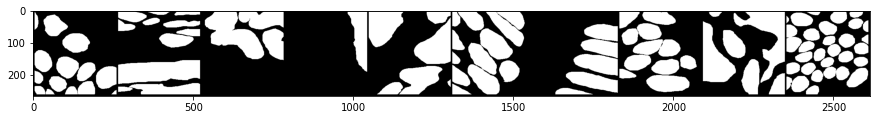

In [ ]:
#Plotting for Comparison
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(torchvision.utils.make_grid(img_test[0:10], nrow=1, padding=5, normalize=True).cpu(),(2,1,0)))
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(torchvision.utils.make_grid(test_output[0:10], nrow=1, padding=5, normalize=True).cpu(),(2,1,0)))
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(torchvision.utils.make_grid(mask_test[0:10], nrow=1, padding=5, normalize=True).cpu(),(2,1,0)))